# M394C Research Project Code

_by Balazs Kustar and Rutvik Choudhary_

---

## Globals

These variables set the type of algebra we are using. 

`TROP_ADD_MODE` selects whether the tropical addition operation is classical min or classical max. 

`TROP_MULT_MODE` selects whether the tropical multiplication operation is classical addition or classical multiplication. 

The valid algebras we study are $(\text{min}, +)$, $(\text{max}, +)$, $(\text{max}, \times)$. While $(\text{min}, \times)$ is technically a possible combination, we really don't care about that one for now...

In [1]:
# sets classical operation for tropical addition
# 0 : min
# 1 : max
TROP_ADD_MODE = 1

# sets classical operation for tropical multiplication
# also equal to the multiplicative identity
# 0 : plus
# 1 : times
TROP_MULT_MODE = 0

---

## Common Tropical Functions

---

**Important note:** We use arrays to represent both row vectors and column vectors. We don't care about the distinction between the two. So if you want to pass in a vector to a function, _always use a 1-D array please!_

---

`t_add(a, b)`

Generic tropical addition. Can tropically add two matrices (entry-wise), two vectors (entry-wise), or two scalars.

---

`t_mult(a, b)`

Generic tropical multiplication. Can tropically add two matrices, a matrix and a vector, a scalar and a matrix, a scalar and a vector, or two scalars.

**Important Note:** 

If you are multiplying a scalar and a matrix or a scalar and a vector, _the scalar must come first!!!_

If you are multiplying a matrix and a vector, _the matrix must come first!!!_

---

`t_scalar_mult(a, b)`

Computes the tropical multiplication of 2 scalars.

---

`t_matr_vec_mult(a, b)`

Computes the tropical multiplication of a $m \times n$ matrix and a $n$-dimensional vector.

**Important note:**

`a` _must_ be the matrix and `b` _must_ be the vector!!!

---

`t_matr_matr_mult(a, b)`

Computes the tropical multiplication of a $m \times n$ matrix and a $n \times s$ matrix.

---

`t_dot(a, b)`

Computes the tropical dot product of two vectors.

---

`t_exp(a, b)`

Computes `a` to the power of `b`, i.e. $$ \underbrace{a \bigotimes a \bigotimes ... \bigotimes a}_{b \text{ times}}$$

---

`t_eigval(matrix)`

Returns the eigenvalues of a tropical matrix.

---

`normalize(vector)`

Normalize a tropical vector.
Scalar multiplies so that the first term is the multiplicative identity.

---

`basis(vectors)`

Given a list of vectors, it removes duplicates, i.e. vectors which are simply tropical scalar multiples of another vector in the set.

---

`t_eigvec(matrix)`

Returns the unique eigenvectors of a tropical matrix. I.e., if one eigenvector is a tropical scalar multiple of another, it removes the duplicate.


In [2]:
import numpy as np


# General tropical addition
# scalar - scalar
# n-vector - n-vector
# nm-matrix - nm-matrix
def t_add(a, b):
    return np.minimum(a, b) if TROP_ADD_MODE == 0 else np.maximum(a, b)


# Tropical mulitplication of two scalars
def t_scalar_mult(a, b):
    assert np.isscalar(a)
    assert np.isscalar(b)
    return a + b if TROP_MULT_MODE == 0 else a * b


# Tropical dot product
# n-vector - n-vector
def t_dot(a, b):
    a = a.flatten()
    b = b.flatten()
    assert (len(a)==len(b))
    
    terms = np.vectorize(t_scalar_mult)(a, b)
    return np.min(terms) if TROP_ADD_MODE == 0 else np.max(terms)


# Tropical multiplicaion of a matrix and a vector
# mn-vector - n-vector
def t_matr_vec_mult(a, b):
    b.flatten()
    m = np.shape(a)[0]
    n = np.shape(a)[1]
    r = len(b)
    assert (n==r)
    
    out = np.zeros(r)
    assert n == r
    for i in range(m):
        out[i] = t_dot(a[i], b)
    return out


# Tropical multiplicaion of two matrices
# mn-matrix - ns-matrix
def t_matr_matr_mult(a, b):
    m = np.shape(a)[0]
    n = np.shape(a)[1]
    r = np.shape(b)[0]
    s = np.shape(b)[1]
    assert (n==r)
    
    c = np.zeros(shape=(m, s))
    for i in range(m):
        for j in range(s):
            c[i][j] = t_dot(a[i], b[:, j])
    return c


# General tropical multiplication
# scalar - scalar
# scalar - vector
# scalar - matrix
# mn-matrix - ns-matrix
# mn-matrix - n-vector
def t_mult(a, b):
    if np.isscalar(a):
        if np.isscalar(b):
            return t_scalar_mult(a, b)
        else:
            return np.vectorize(t_scalar_mult)(a, b)

    if len(np.shape(a)) == 2:
        if len(np.shape(b)) == 2:
            return t_matr_matr_mult(a, b)
        elif len(np.shape(b)) == 1:
            return t_matr_vec_mult(a, b)
        
    # Invalid input
    assert 0


# Tropical exponentiation
def t_exp(a, b):
    return a * b if TROP_MULT_MODE == 0 else a ** b


# Calculate tropical eigenvalue of a square matrix
# TODO: ensure this works with mode2==1
def t_eigval(matrix):
    # ensure matrix is square
    n, m = np.shape(matrix)
    assert n == m
    
    ma = matrix # will store current exponent of matrix
    cur = matrix # will store current sum of matrix powers
    
    for i in range(1,n): # 1 to n-1, since the first power is already stored
        
        # compute matrix^(i+1)
        # this is the (i+1)-length optimal path matrix
        ma = t_mult(ma, matrix)
        
        # divide by path length, and combine with previous matrices
        # in max-times, this should be neg-exponentiation, not division
        cur = t_add(cur, t_exp((1/(i+1)), ma))
        
    # cur now stores the (1...n)-length optimal average-weight paths
    # find optimal value on diagonal (optimal cycle)
    val = cur[0][0]
    for i in range(n):
        val = t_add(val, cur[i][i])
        
    # optimal average-weight cycle weight is equal to tropical eigenvalue
    return val


# Normalize a tropical vector
# Ensure that the first term is the multiplicative identity
def normalize(v):
    if (len(np.shape(v))==2): # column vector
        return t_mult(t_exp(v[0][0],-1), v)
    
    else: # row vector
        return t_mult(t_exp(v[0],-1), v)

    
# Calculate basis of given list of vectors
# TODO: ensure linear combination vectors are also removed
def basis(vectors):
    count = 1
    out = []
    
    # if input is empty, return empty list
    n = len(vectors)
    if (n==0):
        return out
    
    # add the first vector, normalized
    out.append(normalize(vectors[0]))
    
    for i in range(1,n): # iterate over the rest
        vectors[i] = normalize(vectors[i])
        matches = 0
        
        # see if it matches any already in the basis
        for j in range(0,len(out)):
            if ((out[j] == vectors[i]).all()):
                matches = 1
                
        # if no matches, append to output
        if (matches == 0):
            out.append(vectors[i])
            
    return out


# Calculate tropical eigenvectors of a square matrix
# TODO: ensure this works with mode2==1
def t_eigvec(matrix):
    n, m = np.shape(matrix)
    assert n == m

    # subtract/divide out the eigenvalue
    eigval = t_eigval(matrix)
    matrix = t_mult(t_exp(eigval,-1), matrix)
    # eigval(matrix) is now the identity

    # compute "C^+" matrix (optimal paths)
    
    ma = matrix # will store exponents of matrix
    cur = matrix # will build C^+
    for i in range(1,n): # 1 to n-1, since the first power is already stored
        ma = t_mult(ma, matrix)
        cur = t_add(cur, ma)
    
    # find columns where the diagonal entry is the identity
    out = []
    cur = cur.transpose()
    for i in range(n):
        if (cur[i][i] == TROP_MULT_MODE):
            out.append(cur[i])
            
    # compute a normalized basis
    return basis(out)

# Return tropical eigenvalue and eigenvectors
def t_eig(matrix):
    return t_eigval(matrix), t_eigvec(matrix)

## Sample Calculations of Tropical Eigenvalues/Eigenvectors

In [3]:
# TODO

---

## Functions for Calculating the Perron-Forbenius Eigenvalue/Eigenvector

The following code uses the method described on page 7 of [Methods and Applications of (max,+) Linear Algebra](https://hal.inria.fr/inria-00073603/document):

In [4]:
from sympy import *
from scipy.linalg import eig
import matplotlib.pyplot as plt


# Compute transfer matrix
def transfer_matrix(A, h):
    n, m = np.shape(A)
    assert n == m
    out = np.zeros(shape=(n,m))

    for i in range(n):
        for j in range(m):
            out[i][j] = np.exp(A[i][j] * (1/h))
    return out


# Compute transfer PF eval/evecs in max-+
def transfer_ev(A, h):
    n,m = np.shape(A)
    E = np.exp(h*A)
    val, vec = eig(E)
    
    vec = vec.T
    val = np.abs(np.real(val))
    ind = np.argmax(val)
        
    ove = vec[ind]
    if (ove[0] < 0):
        ove = -ove
    
    for i in range(len(ove)):
        ove[i] = (1/h) * np.log(ove[i])
    ova = val[ind]
    ova = (1/h) * np.log(ova)
    return ova, normalize(ove)

# Approximate the limit of the PF-eigenvalue and eigenvector
def pf_eig(A):
    n,m = np.shape(A)
    return transfer_ev(A, 30)

In [62]:
def plotPF(matrix, n=500, div=10):
    x = np.zeros(n)
    y = np.zeros(n)
    for i in range(n):
        val, vec = transfer_ev(matrix, (i+1)/div)
        x[i] = vec[1]
        y[i] = vec[2]
    color = list(reversed(range(n)))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal', adjustable='box')
    ax.scatter(x, y, c=color)

    tval, tvec = t_eig(matrix)
    for i in range(len(tvec)):
        circle = plt.Circle((tvec[i][1], tvec[i][2]), 0.03, color='r', fill=False)
        ax.plot(tvec[i][1], tvec[i][2], 'o', color='black')
        ax.add_artist(circle)

    plt.show()

## Sample Calculation of the Perron-Frobenius Eigenvector

In [63]:
a = np.array([ 0 , -1 , -1])
b = np.array([ -1 , 0 , -1])
c = np.array([ -1 , -1 , 0])
m1 = np.array([a, b, c])

a = np.array([ 0 , -3 , -4])
b = np.array([ -2 , 0 , -4])
c = np.array([ -2 , -3 , 0])
m2 = np.array([a, b, c])

a = np.array([ 0 , -1 , -1])
b = np.array([ -4 , 0 , -1])
c = np.array([ -1 , -1 , -4])
m3 = np.array([a, b, c])

a = np.array([ 0 , 1 , 2])
b = np.array([ 1 , 2 , 5])
c = np.array([ 3 , 2 , 1])
m4 = np.array([a, b, c])

a = np.array([ 0 , -1 , -2])
b = np.array([ -10 , 0 , -1])
c = np.array([ -10 , -1 , -1])
m5 = np.array([a, b, c])

a = np.array([ 0 , -1 , -3])
b = np.array([ 0 , 0 , -1])
c = np.array([ -1 , -1 , -1])
m6 = np.array([a, b, c])

a = np.array([ 0 , -1 , 0])
b = np.array([ -1 , 0 , -1])
c = np.array([ -1 , -1 , -1])
m7 = np.array([a, b, c])

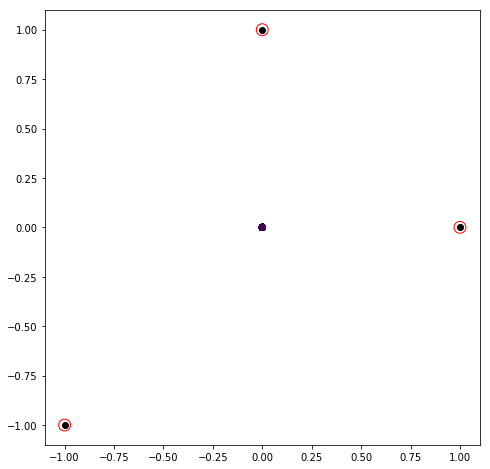

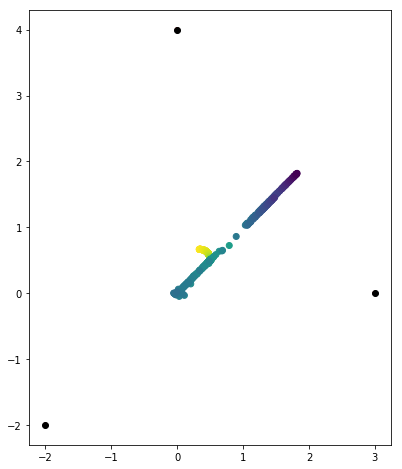

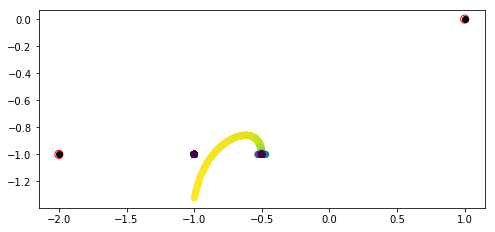

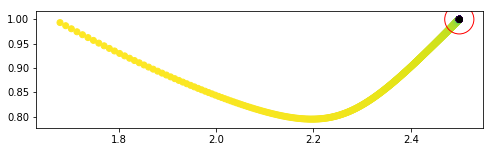

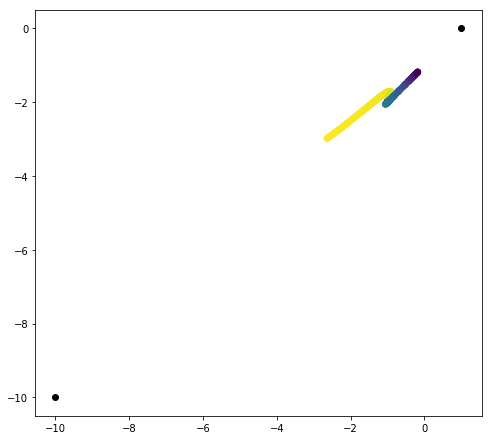

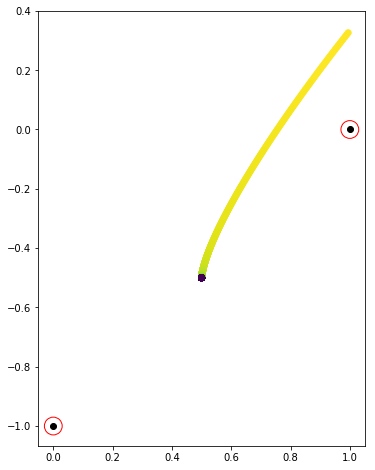

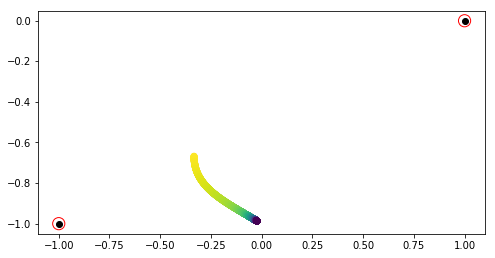

In [65]:
import warnings
warnings.filterwarnings('ignore') #'default' to revert

plotPF(m1, 3000, 100)
plotPF(m2, 3000, 100)
plotPF(m3, 3000, 100)
plotPF(m4, 5000, 100)
plotPF(m5, 3000, 100)
plotPF(m6, 3000, 100)
plotPF(m7, 3000, 100)
